# "MicroMouse" : Motor Selection

Below is an analysis used to determine a suitable motor for a robot designed for Dr. MacIver's lab. The intention of this robot is to act as a predeator and chase mice around a habit.
***

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import csv

## Design Contraints / Requirements

The robot will operate a hexagonal shapped habit with vinyl flooring that is ~3m in length across longest vertices and has various hexagonal shaped obstacles. Ideally, the robot will fit through the smallest potential opening, which given the obstacle spacing is a litte larger than 6cm. 

The mice move up to 1.7 m/s. If possible we would like the robot to move around 3 m/s, but at minimum it should be quicker than the mice, so at least 2 m/s linearly. The micromouse robots use cornering speed around 1 m/s and turn between 60 and 120 degrees.  

# THE CALCULATIONS AND GRAPHS BELOW ARE ACTUAL MICE DATA

Lets load the mice velocity data, so we can use it for simualtions later

In [2]:
# DOWNLOADS FOR MOUSE DATA
# % reset -f
import requests
# from google.colab import files
 
def cast(s):
    cf = True
    try:
        float(s)
    except ValueError:
        cf = False
    ci = True
    if cf:
        try:
            ci = int(s) == float(s)
        except ValueError:
            ci = False
    else:
        ci = False

    if ci:
         return int(s)
    if cf:
         return float(s)
    return s

def download (url, path = None):
    web_get = requests.get(url)
    if not path:
        path = url.split("/")[-1]
    with open(path, "wb") as f:
        f.write(web_get.content)
 


#download modules
download("https://github.com/germanespinosa/images/raw/master/map.py")
download("https://github.com/germanespinosa/images/raw/master/display.py")
download("https://github.com/germanespinosa/images/raw/master/world.py")
download("https://github.com/germanespinosa/images/raw/master/heat_map.py")
download("https://github.com/germanespinosa/images/raw/master/web_resources.py")
download("https://github.com/germanespinosa/images/raw/master/visibility.py")
download("https://github.com/germanespinosa/images/blob/master/data.json?raw=true", "data.json")
download("https://maciver-lab.github.io/plangame/maps/savanna.json")

#configure font
import matplotlib.font_manager as fm
 
download("https://github.com/germanespinosa/images/raw/master/Myriad%20Pro%20Regular.ttf","Myriad-Pro-Regular.ttf")
prop = fm.FontProperties(fname="Myriad-Pro-Regular.ttf")
fm.fontManager.addfont("Myriad-Pro-Regular.ttf")
font_name = prop.get_name()

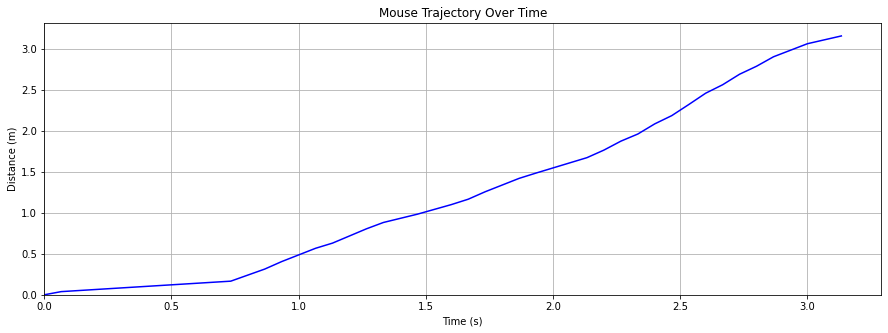

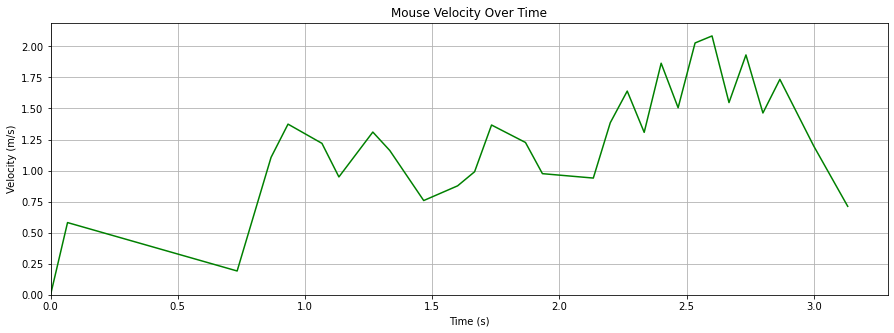

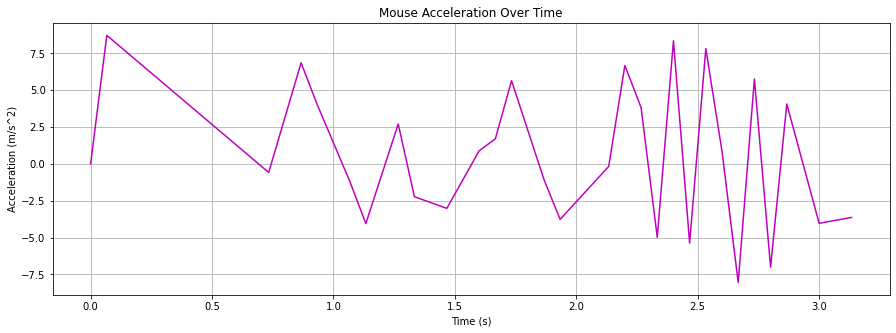

In [3]:
#RAW COORDINATE TEST
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import math
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
from world import World

world_name = "hexa_10_05"
file_name = "20210423_1520_FMM1_10_05_test.json"

w = World(world_name)
x = []
y = []
c = []
for cell in w.cells:
    x.append(cell["location"]["x"])
    y.append(cell["location"]["y"])
    c.append("white" if cell["occluded"] == 0 else "black")

y = [y*math.sqrt(3) for y in y]
# plt.style.use("dark_background")

# fig, ax = plt.subplots(1, 1, figsize=(10, 9))
# plt.scatter(x, y, c=c, alpha=1,  marker="h", s=825)

f = open(file_name)
data = json.load(f)
cmap=plt.get_cmap('jet')
color_index = np.linspace(0, 1,len(data))

# ax.set_title(name)
for j in (data['episodes']):
    count = 0
    x_coord=[]
    y_coord=[]
    distance = []
    distance_meter = []
    velocity = []
    accel = []
    time = []
    frame =[]
    first_coord = [j['trajectories'][0]['location']['x'],
                j['trajectories'][0]['location']['y']]
    first_frame = j['trajectories'][0]['frame']
    previous_coord = first_coord
    previous_frame = first_frame
    previous_dist = 0
    previous_dist_meter = 0
    prev_vel = 0

    fx = -1000
    fy = -1000
    i =1
    for y in (j['trajectories']):
        new_coord = [y['location']['x'],
                      y['location']['y']]

        time.append(y['frame']*(1/15))
        frame.append(y['frame'])

        if fx == -1000:
            fx = new_coord[0]
        if fy == -1000:
            fy = new_coord[1]
        fx = fx * (1-i) + new_coord[0] * i
        fy = fy * (1-i) + new_coord[1] * i
        x_coord.append(fx)
        y_coord.append(fy)
        step_dist = math.sqrt((new_coord[0]-previous_coord[0])**2 + (new_coord[1]-previous_coord[1])**2)
        step_dist_meter = 2.34/(220*20)*step_dist*220*20
        step_time = (y['frame']-previous_frame)*(1/15)

#         total_distance = previous_dist + step_dist
        total_distance_meter = previous_dist_meter + step_dist_meter
#         distance.append(total_distance)
        distance_meter.append(total_distance_meter)
        if step_time == 0:
            velocity.append(0)
        else:
            vel = step_dist_meter/step_time
            velocity.append(vel) 
        count = count + 1;
        previous_frame = y['frame']
        previous_coord = new_coord
#         previous_dist = total_distance
        previous_dist_meter = total_distance_meter
        
y_coord_hex = [y*200*20-(200*20)/2 for y in y_coord]
x_coord_hex = [(1-x)*220*20-(220*20)/2 for x in x_coord]
# print(velocity)

max_velocity = max(velocity)
max_index = velocity.index(max_velocity) 

#PLOT VELOCITIES OVER TIME
# fig2, ax0 = plt.subplots(figsize=(10, 9))

mouse_v2=[]
# i = (.1) # Filter value, this is used to average the velocities
i = 1 # With a filter of one, we get the actual values, not averaged
nv = 0
for v in velocity:
    nv = nv * (1-i) + v * i
    mouse_v2.append (nv)
    
seconds = []
for f in frame:
    sec = (f - 66)/15
    seconds.append(sec)

mouse_accel = []
vel_len = len(mouse_v2)
mouse_accel.append(0)
for k in range(0, vel_len-1):
    vk = mouse_v2[k]
    vk1 = mouse_v2[k+1]
    t1 = seconds[k]
    t2 = seconds[k+1]
    dT = t2 - t1
    dv = vk1 - vk
    a = dv / dT
    mouse_accel.append(a)
    
#     if a > 0:
#         accel.append(a)
#     else:
#         accel.append(0)
    
    
fig10, ax10 = plt.subplots(figsize=(15, 5))
ax10.set_ylabel('Distance (m)')
ax10.set_xlabel('Time (s)')
ax10.plot(seconds,distance_meter, "-b")
ax10.grid(b=None, which='both', axis='both', drawstyle = "steps-mid")
ax10.set_ylim(bottom= 0)
ax10.set_xlim(left= 0)
ax10.set_title("Mouse Trajectory Over Time")

fig0, ax0 = plt.subplots(figsize=(15, 5))
ax0.plot(seconds,mouse_v2, "-g")
ax0.set_ylabel('Velocity (m/s)')
ax0.set_xlabel('Time (s)')
ax0.grid(b=None, which='both', axis='both', drawstyle = "steps-mid")
ax0.set_ylim(bottom= 0)
ax0.set_xlim(left= 0)
ax0.set_title("Mouse Velocity Over Time")

fig100, ax100 = plt.subplots(figsize=(15, 5))
ax100.plot(seconds,mouse_accel, "-m")
ax100.set_ylabel('Acceleration (m/s^2)')
ax100.set_xlabel('Time (s)')
ax100.grid(b=None, which='both', axis='both', drawstyle = "steps-mid")
# ax100.set_ylim(bottom= 0)
ax100.set_title("Mouse Acceleration Over Time")

plt.show()

The mouse velocity vs time graph above just shows instantaneous velocities, so it doesn't mean that the mice reach 2m/s in 2.5 seconds, just that at 2.5 seconds the mouse happened to be moving that fast. So use this graph to get a general idea of the velocity ranges the mice move at. 

## DO I CARE ABOUT DECELERATION OR NOT?

## Electrical motor specs

In order to derive the equations that govern a motor's behavior,  we first have to look at the electrical specs. The electrical power is going to be out input power after all, and the output power will be the mechanical power. 

Simply put, the input electrical power is...
 
$P_e = IV$

*Where I is current and V is Votlage*

However, this Input Power has to account for the Mechanical Output Power ($\tau\omega$) as well as power lost through heat dissipation and such. Therefore...

$IV = (\tau_{out} G)(\frac{\omega_{out}}{G}) + {I}^2 R + LI \frac{dI}{dt}$

*Where $G$ is the gear reduction*

Dividing by $I$ we can get an equation for the Voltage:

$V = \frac{\tau_{out}G}{I} (\frac{\omega_{out}}{G}) + IR + L \frac{dI}{dt}$


$\frac{\tau}{I}$ is a constant value, given Lorentz force law. This constant is called the torque constant $k_t$

$k_t = \frac{\tau}{I}$

$k_t G = \frac{\tau_{out}G}{I}$

$\tau_{out} = \frac{k_t I}{G}$

Rewrite the Voltage equation to incorparate the torque constant...

$V = k_t G \frac{\omega_{out}}{G} + IR + L \frac{dI}{dt}$

Going back to the Speed-Torque curve, we can assume that at a constant speed and constant torque the Voltage equation is reduced to...

$V = k_t G \frac{\omega_{out}}{G} + IR $

Solving for $\omega$ ...

$\omega = \frac{1}{k_t} V - \frac{R}{{k_t}^2} \tau$

Here, we can calculate the no load speed and stall torque given the electrical specs of the motor

$\omega_0 = \frac{V}{k_t}$

$\tau_s = \frac{k_t V}{R}$

## "RACE" SIMULATIONS

Considering that the motors have variable acceleration and velocities, perhaps the best place to start comparing motors is by simulaitng a "race" with various motors. These simulaitons only take into account motor parameters such as the torque constant $k_t$, voltage $V$, a motor's resistance $R$ and so on, parameters which we used in the governing equations above.  


Given the electrical input power equations above, we solved for $\omega$ given a motor's torque constant, voltage and resistance...

$\omega = \frac{1}{k_t} V - \frac{R}{{k_t}^2} \tau$

Now lets rearrange this equation to solve for torque:

$\omega - \frac{1}{k_t} V = - \frac{R}{{k_t}^2} \tau$

$\frac{R}{{k_t}^2} \tau = \frac{1}{k_t} V - \omega$

$R \tau = V k_t - \omega {k_t}^2$

$\tau = \frac{V k_t - \omega {k_t}^2}{R} = \frac{k_t(V - \omega k_t)}{R}$

Assuming a 100% effiecent motor, we can use these mechanical eqautions...

$F = ma$

$\tau = Fr = mar$

$v = \omega r$

$\omega = \frac{v}{r}$


Sub the appropriate equations into $\tau$ and $\omega$...

$\tau = \frac{V k_t - \omega {k_t}^2}{R} = \frac{k_t(V - \omega k_t)}{R}$

$mar = \frac{V k_t - \frac{v}{r} {k_t}^2}{R} = \frac{V k_t}{R} - \frac{v {k_t}^2}{Rr}$

$a = \frac{V k_t}{Rmr} - \frac{v {k_t}^2}{Rm{r}^2}$

$0 = a + \frac{v {k_t}^2}{Rm{r}^2} - \frac{V k_t}{Rmr} $


Now that we've elimated torque and radial velocity from our equation, we have a function that is governed by two non-constant vairbles, acceleration $a$ and linear velocity $v$. Fortunately, both these varibales can be represented by 2nd and 1st order differentials of displacement over time (respectively). Now lets represent our funciton as only dependent on displacement over time....

$\frac{{d}^2 x}{d{t}^2} + \frac{\frac{dx}{dt} {k_t}^2}{Rm{r}^2} - \frac{V k_t}{Rmr} = 0$


Eliminate the constant value so we can solve for a solution:

$\frac{{d}^2 x}{d{t}^2} + \frac{{k_t}^2 \frac{dx}{dt}}{Rm{r}^2} = 0$


Assume the solution will be porpoertional to ${e}^{\lambda t}$ and sub $x(t)= {e}^{\lambda t}$ into the diff eq:

$\frac{{d}^2}{d{t}^2} {e}^{\lambda t} + \frac{{k_t}^2 \frac{d}{dt} {e}^{\lambda t}}{Rm{r}^2} = 0$

${\lambda}^2 {e}^{\lambda t} + \frac{{k_t}^2 \lambda {e}^{\lambda t}}{Rm{r}^2} = 0$

$({\lambda}^2 + \frac{{k_t}^2 \lambda}{Rm{r}^2}) {e}^{\lambda t} = 0$


Since ${e}^{\lambda t}$ CANNOT equal 0...

${\lambda}^2 + \frac{{k_t}^2 \lambda}{Rm{r}^2} = 0$

$\frac{\lambda ({k_t}^2 + \lambda Rm{r}^2)}{Rm{r}^2} = 0$


Solving for $\lambda$....

$\lambda = 0$

and

$\lambda = - \frac{{k_t}^2}{Rm{r}^2}$


For complementary solutions a root of $\lambda = 0$ gives $x_1(t) = c_1$

Also a root $\lambda = - \frac{{k_t}^2}{Rm{r}^2}$ gives $x_2(t) = c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}}$

Therefore the general solution is 

$x(t) = x_1 (t) + x_2 (t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}}$


Great! Now determine the particular solution by the method of undetermined coefficients where $x_p(t) = a_1 t$:

$\frac{dx_p(t)}{dt} = \frac{d}{dt}(a_1 t) = a_1$

$\frac{{d}^2 x_p(t)}{d{t}^2} = \frac{{d}^2}{d{t}^2} (a_1 t) = 0$

$\frac{{d}^2 x_p (t)}{d{t}^2} + \frac{{k_t}^2 \frac{d x_p (t)}{dt}}{Rm{r}^2} = \frac{k_t V}{R m r}$

$\frac{{k}^2 a_1}{Rm{r}^2} = \frac{k_t V}{Rmr}$

$a_1 = \frac{rV}{k_t}$

$x_p(t) = \frac{rVt}{k_t}$


Making the general solution:

$x(t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$


Now lets solve with our givens $x(0) = 0$ and $\frac{dx}{dt}(0) = 0$. For t = 0 and x(0) = 0...

$c_1 + c_2 = 0$


Taking the derivative of our general solution we get:

$\frac{dx(t)}{dt} = \frac{rV}{k} - \frac{{k_t}^2 c_2 e^{-\frac{{k_t}^2 t}{Rm{r}^2}}}{Rm{r}^2}$


Subbing in $\frac{dx}{dt}(0) = 0$ for t = 0...

$\frac{rV}{k} - \frac{{k}^2 c_2}{Rm{r}^2} = 0$

$c_2 = \frac{Vm {r}^3 R}{{k}^3}$


Which means...

$c_1 = - \frac{Vm {r}^3 R}{{k}^3}$


Plugging the constants into the general solution:

$x(t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$

$x(t) = - \frac{V Rm {r}^3}{{k}^3} + \frac{VRm {r}^3}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$

$x(t) = rV(- \frac{Rm {r}^2}{{k}^3} + \frac{Rm {r}^2}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{t}{k_t})$

$x(t) = rV( \frac{t}{k_t} + \frac{Rm {r}^2}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} - \frac{Rm {r}^2}{{k}^3})$

$x(t) = \frac{rV( {k_t}^2 t + Rm{r}^2 ({e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} - 1))}{{k_t}^3}$

We now have an equation for displacement over time, which, aside from the motor specs, is only dependent on wheel radius and time. But there are two more elements that have to be taken into consideration: gear reductions and motor efficieny. Luckily, the only varible influcened by a gear reduction and motor efficieny is $k_t$. This is because...

$k_t = \frac{\tau}{I}$

And if you multiply the torque by the gear reduction $G$ then the torque constant $k_t$ must be proportionately scaled. 

$k_t G = \frac{\tau_{out}G}{I}$

Given the equation below for efficiency $\eta$, how can I incorporate that into my simulation equation?

$\eta = \frac{\tau_{out} \omega}{IV} = \frac{k_t \omega}{V}$

<!-- $k_t G \eta = \frac{\tau_{out}G \eta}{I}$   **Is this correct?** -->

Therefore our final equation that we will be simulating is (WITHOUT EFFICIENCY)...

$x(t) = \frac{rV( {(k_t G)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - 1))}{{(k_t G)}^3}$

<!-- $x(t) = \frac{rV( {(k_t G \eta)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G \eta)}^2 t}{Rm{r}^2}} - 1))}{{(k_t G \eta)}^3}$ -->

## Robot Velocity, take derivative of x(t) equation. 

Given the displacement vs time equation from before...

$x(t) = \frac{rV( {(k_t G)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - 1))}{{(k_t G)}^3}$

Take the derivative of that equation to find the realtionship of velocity vs time. Lets start by rearranging it a bit.

$x(t) = \frac{rV}{{(k_t G)}^3}({(k_t G)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - 1))$

$x(t) = \frac{rV}{{(k_t G)}^3}({(k_t G)}^2 t + Rm{r}^2 {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - Rm{r}^2)$

Now lets take the derivative with respect to $t$...

$x'(t) = \frac{rV}{{(k_t G)}^3} ({(k_t G)}^2 + Rm{r}^2 \frac{{(-k_t G)}^2}{Rm{r}^2} {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x'(t) = \frac{rV}{{(k_t G)}^3} ({(k_t G)}^2 -{{(k_t G)}^2} {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x'(t) = \frac{rV}{(k_t G)} (1 - {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

## Robot Acceleration, take derivative of x'(t) equation. 

Given the velocity vs time equation from before...

$x'(t) = \frac{rV}{{(k_t G)}^3} ({(k_t G)}^2 -{{(k_t G)}^2} {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

Take the derivative of that equation to find the realtionship of accleration vs time.

$x''(t) = \frac{rV}{{(k_t G)}^3} (-{{(k_t G)}^2} \frac{{-(k_t G)}^2}{Rm{r}^2}  {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x''(t) = \frac{rV}{{(k_t G)}^3} (\frac{{(k_t G)}^4}{Rm{r}^2}  {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x''(t) = \frac{V k_t G }{Rmr}  {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}}$

## Find the power at each time step

Given the linear velocity derived above and a given wheel radius, calculate the angular velocity at each time step. Also given the mouse's acceleration at each time step, a robot's mass and again wheel radius, determine the torque at each timestep. With angualr velocity and torque, determine the power at each time step

From our previous calculations, we know that we have the input electrical power $P_e = IV$ and our output mechancial power $P_{mech} = \tau \omega$. However, not all of the input power is converted to electrical power since motors are not 100% efficient. The effeciency of a motor is determined by...

$\eta = \frac{P_{mech}}{P_e} =  \frac{\tau_{out} \omega}{IV}$

In other words

<!-- P_{input} = P_e = \frac{P_{mech}}{\eta} + {I}^2 R = \frac{\tau_{out} \omega}{\eta} + {I}^2 R -->

$P_{input} = P_e = \frac{P_{mech}}{\eta} = \frac{\tau_{out} \omega}{\eta}$

Now that we have our simualtion equations, its time to upload the motor information and simualte!

In [4]:
tile_len = 0.1
time = seconds

def disp_simulation(m_kg, kt, G, input_V, motor_R, wheel_rad, eta):
    # m_kg: total mass in kg, kt in mNm/A, input V in Volts, motor R in ohms,  wheel_rad in m
    
    disp = []
    
    ktGn = (kt / 1000) * G
    rV = wheel_rad * input_V
    Rmr2 = motor_R * m_kg * math.pow(wheel_rad, 2)
    
    for t in time:
        ktGn2t = (math.pow(ktGn, 2)) * t
        expon = math.exp( -ktGn2t / Rmr2)
    
        x_t = (rV * (ktGn2t + (Rmr2 * (expon - 1)))) / math.pow(ktGn, 3)
        disp.append(x_t)
        
    return disp

def vel_simulation(m_kg, kt, G, input_V, motor_R, wheel_rad, eta):
    # m_kg: total mass in kg, kt in mNm/A, input V in Volts, motor R in ohms,  wheel_rad in m
    
    vel = []
    
    ktGn = (kt / 1000) * G 
    rV = wheel_rad * input_V
    Rmr2 = motor_R * m_kg * math.pow(wheel_rad, 2)
    
    for t in time:
        ktGn2 = (math.pow(ktGn, 2))
        ktGn2t = ktGn2  * t
        expon = math.exp( -ktGn2t / Rmr2)
    
        v_t = (rV / (math.pow(ktGn, 3))) * (ktGn2 - (ktGn2 * expon))
        
        if v_t < 3.0:
            vel.append(v_t)
        else:
            vel.append(3.0)
        
    return vel


def input_power(m_accel, wheel_r, lin_vel, eta, mass, I, R):
    
    P_input = []
    tau = []
    w = []
    
    for i in range(0,len(time)):
        torque = mass * (m_accel[i]) * wheel_r
        omega = (lin_vel[i]) / wheel_r
        
        tau.append(torque)
        w.append(omega)

        Pm = torque * omega
        Pi = (Pm / eta)
#         P_input.append(Pi)
        P_input.append(abs(Pi))
    
    return P_input, tau, w

In [5]:
# For the small Didel motor MK06-4.5
m_battery_g = 10
m_other = 7
m_equip = m_battery_g + m_other

def get_motor_info(G, time, motor_diam, kt, single_motor_m, input_V, motor_R, motor_stall_t, motor_no_load_RPM, motor_eff): 
    
    displacement = []
    vel = []
    accel = []
    power = []

    motor_stall_t = motor_stall_t * 2 # Multiply by 2 since we have 2 motors
    
    m_total = ((single_motor_m*2) + m_battery_g + m_other) / 1000
    print(f"Mass total is {m_total}kg")
    
    no_load_w = (2*math.pi*motor_no_load_RPM) / 60
    
    motor_rad = (motor_diam / 2) 
    wheel_rad = (motor_rad + 5) / 1000 ## Use a clearance of 5mm for the radius
    
    I = input_V / motor_R
    
    displacement = disp_simulation(m_total, kt, G, input_V, motor_R, wheel_rad, motor_eff)
    
    vel = vel_simulation(m_total, kt, G, input_V, motor_R, wheel_rad, motor_eff)

    power1, tor1, w1 = input_power(mouse_accel, wheel_rad, mouse_v2, motor_eff, m_total, I, motor_R)
#     power1, tor1, w1 = input_power(mouse_accel, wheel_rad, vel, motor_eff, m_total, I, motor_R)
    
    return displacement, vel, power1, tor1, w1

# SIMULATE THE MOTOR TO COMPARE DISPLACEMENTS, VELOCITIES AND POWERS BETWEEN MOTOR'S AND MICE INFORMATION

# Start with the MK06-4.5

THE BLACK DOTTED LINE REPRESENTS MAX POWER
Mass total is 0.01964kg


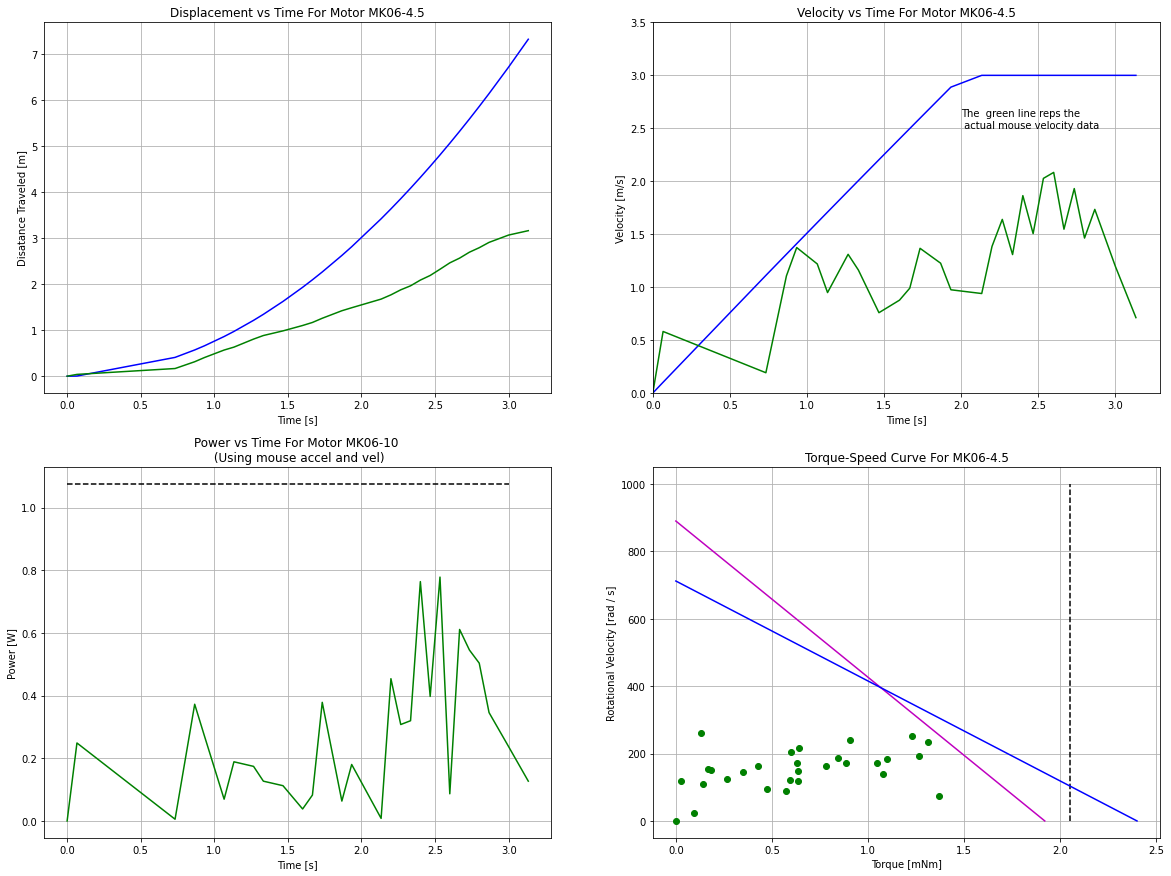

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [6]:
G1 = 1
G2 = 4
G3 = 5
print("THE BLACK DOTTED LINE REPRESENTS MAX POWER")
# These are approximate weights of some quick research I did into other parts we'll need
motor_diam = 6 
single_motor_m = 1.32 
input_V = 3
motor_R = 4.5
motor_stall_t = 0.24
motor_no_load_RPM = 34000 
motor_eff = 0.4
V_nom = 2.2

I_max = input_V / motor_R
P_max = I_max * input_V
P_nom = V_nom * (V_nom/motor_R)

kt = motor_stall_t / I_max

disp, vel, power, tor, w = get_motor_info(G1, time, motor_diam, kt, single_motor_m, input_V, motor_R, motor_stall_t, motor_no_load_RPM, motor_eff)

tau_mouse = []
for t in tor:
    tau_mouse.append(abs(t) * 1000)

omg_mouse = []
for w in w:
    omg_mouse.append(abs(w))
    
mass_max = 0.02
accel_max = 8.2
wheel_rad = 1.25/100
tau_max = (mass_max * accel_max * wheel_rad)*1000
    
motor_stall_t = motor_stall_t * 2 # Multiply by 2 since we have 2 motors
no_load_w = (2*math.pi*motor_no_load_RPM) / 60

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
############## Make the first graph a Dist vs Time graph for one tile (0.1m) ####################
ax1.plot(time, disp, '-b')
ax1.plot(seconds, distance_meter, '-g')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Disatance Traveled [m]')
ax1.grid(b=None, which='both', axis='both')
# ax1.text(0.5, 3, f"The  green line reps the \n actual mouse trajectory data")
# ax1.set_ylim(bottom= 0, top = 0.1)
# ax1.set_xlim(left= 0, right = 0.25)
ax1.set_title(f'Displacement vs Time For Motor MK06-4.5')

############## Make the second graph a Vel vs Time graph ####################
ax2.plot(time, vel, '-b')
ax2.plot(seconds, mouse_v2, "-g") # Plot the mouse data
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Velocity [m/s]')
ax2.grid(b=None, which='both', axis='both')
ax2.text(2.0, 2.5, f"The  green line reps the \n actual mouse velocity data")
ax2.set_ylim(bottom= 0, top = 3.5)
ax2.set_xlim(left= 0)
ax2.set_title(f'Velocity vs Time For Motor MK06-4.5')

############# Make the third graph a Power vs Time graph ####################
ax3.plot(time, power, '-g')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Power [W]')
# ax3.hlines(P_max, 0, 3.0, color="black", linestyle="dashed")
ax3.hlines(P_nom, 0, 3.0, color="black", linestyle="dashed")
ax3.grid(b=None, which='both', axis='both')
ax3.set_title(f'Power vs Time For Motor MK06-10 \n (Using mouse accel and vel)')

############## Make the fourth graph: Torque-speed curve graph #################### 
ax4.plot(tau_mouse, omg_mouse, "og")
# ax4.plot([0, motor_stall_t*2], [no_load_w, 0], "-b")
ax4.plot([0, motor_stall_t*G2], [no_load_w/G2, 0], "-m")
ax4.plot([0, motor_stall_t*G3], [no_load_w/G3, 0], "-b")
ax4.vlines(tau_max, 0, 1000, linestyle = "dashed", color = "black")
ax4.grid(b=None, which='both', axis='both')
ax4.set_xlabel('Torque [mNm]')
ax4.set_ylabel('Rotational Velocity [rad / s]')
ax4.set_title(f'Torque-Speed Curve For MK06-4.5')
    

plt.show()

print("_________________________________________________________________________________________________________________")
print("_________________________________________________________________________________________________________________\n")

## EXAMINE DIFFERENT TRAJECTORIES AND GEAR RATIOS
 
 Lets play with gear ratios and these motors. See what the trajectories look like across 1 tile, across 5 tiles, 
 10 tiles, and then the whole arena

THE BLACK DOTTED LINE REPRESENTS MAX TORQUE AT ACCELERATION = 8.2 M/S^2

THE GREEN DOTS REPRESENT THE POWER CALCULATED FROM EACH TIMESTEP OF THE MOUSE DATA

Mass total is 0.01964kg
Mass total is 0.01964kg
Mass total is 0.01964kg
No load RPM 34000 and omega=3560.471674068432
Average current is 1.760730596750283A


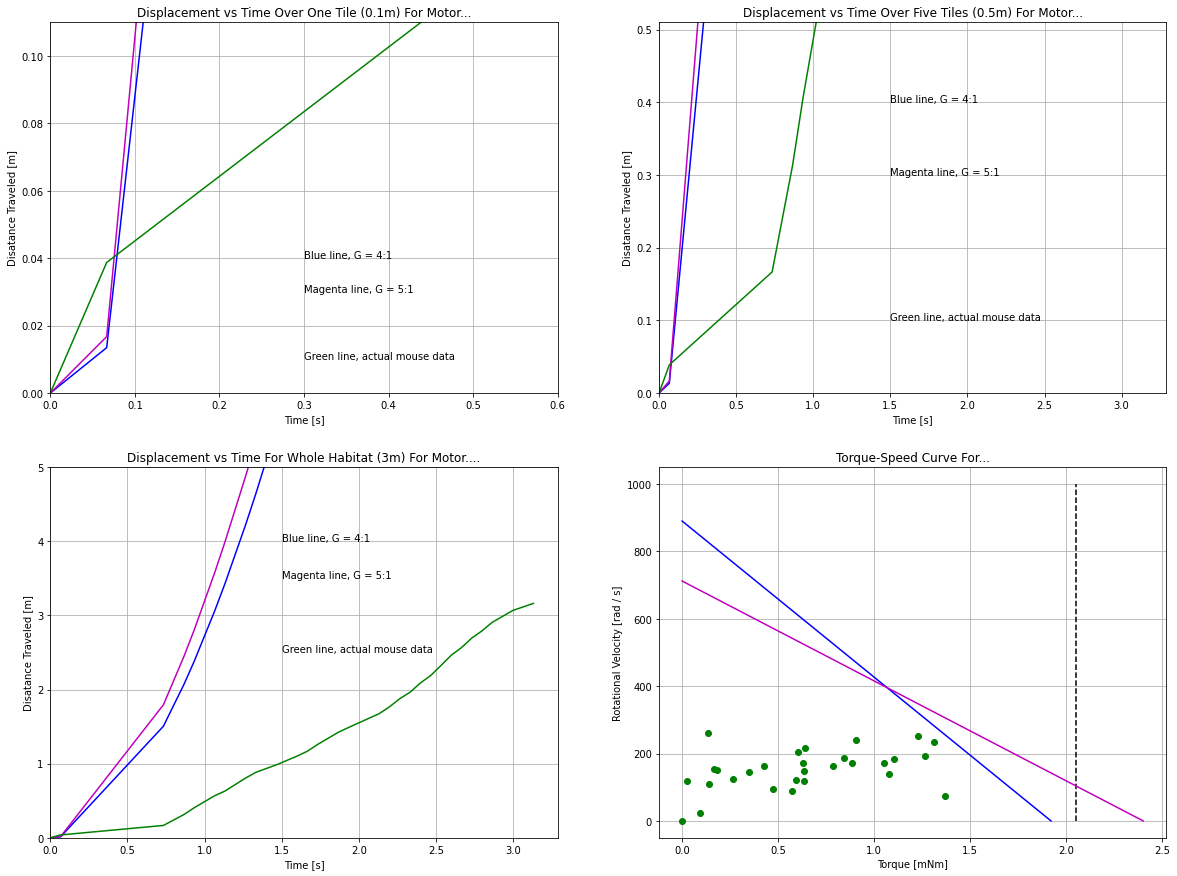

_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [7]:
                                                # Plot 2W Motors #
print("THE BLACK DOTTED LINE REPRESENTS MAX TORQUE AT ACCELERATION = 8.2 M/S^2\n")
print("THE GREEN DOTS REPRESENT THE POWER CALCULATED FROM EACH TIMESTEP OF THE MOUSE DATA\n")
    
disp_g1, vel_g1, power_g1, tor_g1, w_g1 = get_motor_info(G1, time, motor_diam, kt, single_motor_m, input_V, motor_R, motor_stall_t, motor_no_load_RPM, motor_eff)
disp_g2, vel_g2, power_g2, tor_g2, w_g2 = get_motor_info(G2, time, motor_diam, kt, single_motor_m, input_V, motor_R, motor_stall_t, motor_no_load_RPM, motor_eff)
disp_g3, vel_g3, power_g3, tor_g3, w_g3 = get_motor_info(G3, time, motor_diam, kt, single_motor_m, input_V, motor_R, motor_stall_t, motor_no_load_RPM, motor_eff)
# disp_g4, vel_2W_g4, power_2W_g4, tor_2W_g4, w_2W_g4 = get_motor_info(G4, i, time, all_motor_diam_2W, all_motor_kt_2W, all_single_motor_weight_2W, all_nominal_V_2W, all_motor_R_2W, all_motor_stall_t_2W, all_motor_no_load_RPM_2W, all_motor_eff_2W)
    
print(f"No load RPM {motor_no_load_RPM} and omega={no_load_w}")

I_aves = []
for torque in tau_mouse:
    i = torque / kt
    I_aves.append(i)

I_average = (sum(I_aves)) / (len(I_aves))
print(f"Average current is {I_average}A")

fig, ((ax20, ax21), (ax22, ax23)) = plt.subplots(2, 2, figsize=(20, 15))

############## Make the first graph: One Tile vs Time graph ####################
ax20.plot(seconds, disp_g2, '-b')
ax20.plot(seconds, disp_g3, '-m')
# ax20.plot(seconds, disp_g4, '-', color='orange')
ax20.plot(seconds,distance_meter, '-g')
ax20.set_xlabel('Time [s]')
ax20.set_ylabel('Disatance Traveled [m]')
ax20.grid(b=None, which='both', axis='both')
ax20.text(0.3, 0.04, f"Blue line, G = {G2}:1")
ax20.text(0.3, 0.03, f"Magenta line, G = {G3}:1")
# ax20.text(0.3, 0.02, f"Orange line, G = {G4}:1")
ax20.text(0.3, 0.01, f"Green line, actual mouse data")
ax20.set_ylim(bottom= 0, top = 0.11)
ax20.set_xlim(left= 0, right = 0.6)
ax20.set_title(f'Displacement vs Time Over One Tile (0.1m) For Motor...')

############## Make the second graph: Five tiles vs Time graph ####################
ax21.plot(seconds, disp_g2, '-b')
ax21.plot(seconds, disp_g3, '-m')
# ax21.plot(seconds, disp_g4, '-', color='orange')
ax21.plot(seconds,distance_meter, '-g')
ax21.set_xlabel('Time [s]')
ax21.set_ylabel('Disatance Traveled [m]')
ax21.text(1.5, 0.4, f"Blue line, G = {G2}:1")
ax21.text(1.5, 0.3, f"Magenta line, G = {G3}:1")
# ax21.text(1.5, 0.2, f"Orange line, G = {G4}:1")
ax21.text(1.5, 0.1, f"Green line, actual mouse data")
ax21.grid(b=None, which='both', axis='both')
ax21.set_ylim(bottom= 0, top = 0.51)
ax21.set_xlim(left= 0)
ax21.set_title(f'Displacement vs Time Over Five Tiles (0.5m) For Motor...')

############## Make the third graph: Dist vs Time graph ####################
ax22.plot(seconds, disp_g2, '-b')
ax22.plot(seconds, disp_g3, '-m')
# ax22.plot(seconds, disp_g4, '-', color='orange')
ax22.plot(seconds,distance_meter, '-g')
ax22.set_xlabel('Time [s]')
ax22.set_ylabel('Disatance Traveled [m]')
ax22.grid(b=None, which='both', axis='both')
ax22.text(1.5, 4, f"Blue line, G = {G2}:1")
ax22.text(1.5, 3.5, f"Magenta line, G = {G3}:1")
# ax22.text(1.5, 3, f"Orange line, G = {G4}:1")
ax22.text(1.5, 2.5, f"Green line, actual mouse data")
ax22.set_ylim(bottom= 0, top = 5.0)
ax22.set_xlim(left= 0)
ax22.set_title(f'Displacement vs Time For Whole Habitat (3m) For Motor....')

############## Make the fourth graph: Torque-speed curve graph #################### 
ax23.plot(tau_mouse, omg_mouse, "og")
ax23.plot([0, motor_stall_t*G2], [no_load_w / G2, 0], "-b")
ax23.plot([0, motor_stall_t*G3], [no_load_w / G3, 0], "-m")
# ax23.plot([0, motor_stall_t*G4], [no_load_w / G4, 0], "-", color = "orange")
ax23.vlines(tau_max, 0, 1000, linestyle = "dashed", color = "black")
ax23.grid(b=None, which='both', axis='both')
ax23.set_xlabel('Torque [mNm]')
ax23.set_ylabel('Rotational Velocity [rad / s]')
ax23.set_title(f'Torque-Speed Curve For...')

plt.show()

#     print(f"""Minimum Torque needed is {round(tau_max_2W, 1)} at omega {round(w_3ms_2W)}rad/s for a 
#     max accel {a_max}m/s^2 which draws {round(I_max_2W,1)}A""")
#     print(f"Wheel rad is {wheel_rad_2W*100}cm and RPM is {RPM_3ms_2W}")
print("_________________________________________________________________________________________________________________")
print("_________________________________________________________________________________________________________________\n")

## Matt's Notes

For any choice you need to know:
1. What is the minimum gear ratio to achieve the required torque.
   - If mice have 8 m/s^2, let's set 8.2m/s that as the acceleration goal (1m/s^2 is a lot of acceleration)
2. What is the maximum gear ratio such that you meet the velocity requirement?
     - Let's set 3m/s as this goal: it seems like the mice can achieve something near there at times
    

# Considering most of these are going to be too long regarless, lets asses the current consumption. 

## Eh I guess we can do a quick length assessment too

In [8]:
len1 = 10 / 10

nom_current1 = 0.41 #gotta check this...

stall_current1 = I_max * 2

print(f"""For 2 MK06-4.5 motors... 
          Single Motor Length: {len1}cm
          Double Motor Length: {round(len1*2, 1)}cm
          Nominal Current for both motors: {nom_current1}A
          Stall Current for both motors: {stall_current1}A\n""")

For 2 MK06-4.5 motors... 
          Single Motor Length: 1.0cm
          Double Motor Length: 2.0cm
          Nominal Current for both motors: 0.41A
          Stall Current for both motors: 1.3333333333333333A



# Battery Calculations

In [9]:
# def battery_calc(motor_ave_I, motor_C_rate, motor_V, motor_max_I, battery_V, battery_C_max, battery_Ah):

#     ## Current compairison
#     I_C = motor_C_rate * battery_Ah
#     I_rated_C = battery_C_max * battery_Ah

#     ## Average Power comparison
#     motor_ave_power_input = motor_ave_I * motor_V 
#     battery_ave_power_output = I_C * battery_V

#     ## Max Power comparison
#     motor_max_power_input = motor_max_I * motor_V 
#     battery_max_power_output = I_rated_C * battery_V

#     print(f"The average motor current {motor_ave_I}A should be less than the current draw... {I_C}A")
#     print(f"The max motor current {motor_max_I}A should be less than the current draw at {battery_C_max}C... {I_rated_C}A")
#     print(f"The average motor power {motor_ave_power_input}W should be less than the power at 1C... {battery_ave_power_output}W")
#     print(f"The average motor power {motor_max_power_input}W should be less than the power at {battery_C_max}C... {round(battery_max_power_output, 1)}W")

In [20]:
def battery_calc(motor_ave_I, motor_C_rate, motor_V, motor_max_I, battery_V, battery_C_max, battery_Ah):
    
    # Determine Energy of battery
    E = battery_V * battery_Ah # in Wh
    
    # Determine the Ah needed for the motor given the motor used less V than battery is rated for
    Ah = E / motor_V # This is how many amps we can draw in 1 hour
    
    min45 = Ah * 1.33
    min30 = Ah * 2
    min20 = Ah * 3
    min15 = Ah * 4
    
    print(f"For a battery of {battery_V}V and capacity of {battery_Ah}Ah, I need {motor_ave_I}A to power BOTH motors")
    print(f"If the motor operates at {motor_V}V, then we get {round(Ah, 2)}Ah from it, so {round(Ah, 2)}A in one hour")
    print(f"For 45 minutes: {round(min45,3)}A 30 minutes: {round(min30,3)}A, for 20 minutes: {round(min20,3)}A, for 15 minutes: {round(min15,3)}A")

In [21]:
motor_ave_I = 0.41 * 2
motor_C_rate = 1

motor_V1 = 3.5
motor_max_I = I_max 

battery_V1 = 3.7
battery_C_max1 = 20 
battery_Ah1 = 420/1000

print(f"For {battery_V1}V battery")
battery_calc(motor_ave_I, motor_C_rate, motor_V1, motor_max_I, battery_V1, battery_C_max1, battery_Ah1)

For 3.7V battery
For a battery of 3.7V and capacity of 0.42Ah, I need 0.82A to power BOTH motors
If the motor operates at 3.5V, then we get 0.44Ah from it, so 0.44A in one hour
For 45 minutes: 0.591A 30 minutes: 0.888A, for 20 minutes: 1.332A, for 15 minutes: 1.776A


# Friction Calculation

In [18]:
mass_g = 3.4 # grams
mass_kg = mass_g / 1000

deg = 2 # degrees
rad = (deg * math.pi) / 180

g = 9.8

Fn = mass_kg * g * math.cos(rad)
Fg = mass_kg * g * math.sin(rad)

tan = math.tan(rad)

u_s = Fg / Fn

print(f"u_k is {round(u_s, 3)} or {round(tan, 3)}")

u_k is 0.035 or 0.035
